In [1]:
import numpy as np
import os
import pandas as pd
import time
import math
import re
from itertools import groupby
from operator import itemgetter
# package for io 
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers import tiff_reader, OmeTiffReader


import itertools
from skimage import measure as skmeasure
import datetime
from CustomFunctions import shparam_mod

from skimage.morphology import disk
from skimage.filters import median, gaussian


# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)
    

def mygrouper(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))
    


def get_intensity_features(img, seg):
    features = {}
    input_seg = seg.copy()
    input_seg = (input_seg>0).astype(np.uint8)
    input_seg_lcc = skmeasure.label(input_seg)
    for mask, suffix in zip([input_seg, input_seg_lcc], ['', '_lcc']):
        values = img[mask>0].flatten()
        if values.size:
            features[f'intensity_mean{suffix}'] = values.mean()
            features[f'intensity_std{suffix}'] = values.std()
            features[f'intensity_1pct{suffix}'] = np.percentile(values, 1)
            features[f'intensity_99pct{suffix}'] = np.percentile(values, 99)
            features[f'intensity_max{suffix}'] = values.max()
            features[f'intensity_min{suffix}'] = values.min()
        else:
            features[f'intensity_mean{suffix}'] = np.nan
            features[f'intensity_std{suffix}'] = np.nan
            features[f'intensity_1pct{suffix}'] = np.nan
            features[f'intensity_99pct{suffix}'] = np.nan
            features[f'intensity_max{suffix}'] = np.nan
            features[f'intensity_min{suffix}'] = np.nan
    return features



def dist_f(a1, b1, c1, a2, b2, c2):

    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

# Function to find Angle
def angle_distance(a1, b1, c1, a2, b2, c2):
    a1,b1,c1 = [a1,b1,c1]/np.linalg.norm([a1,b1,c1])
    a2,b2,c2 = [a2,b2,c2]/np.linalg.norm([a2,b2,c2])
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

In [8]:
############################# RUN TRACKMATE TRACKING ON SEGMENTED IMAGES ##################################

In [9]:
from CustomFunctions.track_functions import segment_caax_tracks_confocal_40x_fromsingle

#### get together all images on the NAS #########

ip = 0.3394 #um / pixel .2285
step = 0.7 # um

#### directory info
bigdir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/'
foldlist = ['20231116',
           '20231122']
savedir = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_37C_10s/Tracking_Images/'

####  TZYX shape of the image
imshape = (361,150,1024,1024)

for f in foldlist:
    ims = [o for o in os.listdir(bigdir+f+'/') if '37C' in o]
    for i in ims:
        #make the savedir if it doesn't exist
        if not os.path.exists(savedir+i+'/'):
            os.makedirs(savedir+i+'/')
        #directory of all the slices for this movie
        imdir = bigdir+f+'/'+i+'/Default/'
        
        
        ##### automatically detect image size
#         #sort the list of images and get the last one
#         last = sorted([o for o in os.listdir(imdir) if o.endswith('tif')])[-1]
#         #get stats about acquisition
#         cc,pos,maxtime,maxslices = [x for x in re.findall('\d*', last) if len(x)>1]
#         maxtime = int(maxtime)+1
#         maxslices = int(maxslices)+1
#         #open that image to get x,y size
#         shape = tiff_reader.TiffReader(imdir+last).shape
        
        results = []
        if __name__ ==  '__main__':
        # use multiprocessing to perform segmentation and x,y,z determination
            pool = multiprocessing.Pool(processes=60)
            for t in range(imshape[0]):
                pool.apply_async(segment_caax_tracks_confocal_40x_fromsingle, args=(imdir,
                                                                                    imshape[-3:],
                                                                                    ip,
                                                                                    step,
                                                                                    t, ), 
                                 callback=collect_results)
            pool.close()
            pool.join()
            


        #organize the semented frames into a segmented stack
        segmented_img = np.zeros((imshape[0],
                                 results[0][3][-3],
                                 results[0][3][-2],
                                 results[0][3][-1]))
        for r in results:
            fr = r[2]
            segmented_img[fr,:,:,:] = r[1]    

        #covert to more compact data type
        segmented_img = segmented_img.astype(np.uint8)

        #save the segmented image
        OmeTiffWriter.save(segmented_img, savedir+i+'/'+i+'_segmented.ome.tiff', dim_order = "TZYX", overwrite_file=True)


        #save the skimage region props
        df = pd.DataFrame()
        for d in results:
            df = df.append(pd.DataFrame(d[0], columns = ['cell', 
                         'frame', 'z_min', 'y_min', 
                        'x_min','z_max', 'y_max', 'x_max',
                       'z', 'y', 'x', 'z_range',
                       'area', 'convex_area', 'extent',
                       'minor_axis_length', 'major_axis_length',
                        'intensity_avg', 'intensity_max', 'intensity_std']))
        df = df.sort_values(by = ['frame','cell'])
        df.to_csv(savedir+i+'/'+i+'_region_props.csv')
        
        print(f'Finished processing {i}')

Finished processing 20231116_488EGFP-CAAX_3mA_37C_1
Finished processing 20231116_488EGFP-CAAX_3mA_37C_2
Finished processing 20231116_488EGFP-CAAX_3mA_37C_3
Finished processing 20231122_488EGFP-CAAX_3mA_37C_1
Finished processing 20231122_488EGFP-CAAX_3mA_37C_2


In [2]:
############### SEGMENT AND SAVE CELLS ################################

############## alignment by chemical gradient ###################

from scipy.spatial import KDTree, distance
from itertools import groupby
from operator import itemgetter
from scipy import interpolate
import re
from aicsimageio.readers.bioformats_reader import BioformatsReader

#import the cell segmentation and rotation function
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# import_path = 'C:/Users/Aaron/Documents/PythonScripts/CustomFunctions'
# sys.path.insert(1, import_path)
from CustomFunctions.segment_cells2short import seg_confocal_40x_memonly_fromslices

from CustomFunctions.persistance_activity import get_pa, velocity_and_distance, DA_3D


# path to folder(s)
base = 'E:/Aaron/Galvanotaxis_Confocal_40x_37C_10s/'
folder_fl = base+'Tracking_Images/'
filelist_fl = os.listdir(folder_fl)
savedir = base+'Processed_Data/'
#make the savedir if it doesn't exist
if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(datadir):
    os.makedirs(datadir)
raw_dir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/'

#parameters for segmentation
xy_buffer = 12 #pixels
z_buffer = 8 #pixels
xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
interval = 10
intthresh = 120 #for the half shrunken images, determined by manually crossreferencing
imshape = (150,1024,1024)



# u = filelist_fl[2]


for u in filelist_fl:

    ################## align trackmate data with region props data ################
    rpcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("region_props.csv")][0]
    rp = pd.read_csv(folder_fl + u + '/' + rpcsv, index_col = 0)
    tmcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("TrackMateLog.csv")][0]
    tm = pd.read_csv(folder_fl + u+ '/' + tmcsv)
    #fix trackmate columns to get names right and units in microns
    tm['x'] = tm.POSITION_X*xyres
    tm['y'] = tm.POSITION_Y*xyres
    tm['z'] = tm.POSITION_Z*zstep
    #make kdtree and query with trackmate log
    kd = KDTree(rp[['frame','x','y','z']].to_numpy())
    dd, ii = kd.query(tm[['FRAME','x','y','z']])
    df_track = pd.concat([tm.drop(columns=['POSITION_X','POSITION_Y','POSITION_Z']), 
                        rp.iloc[ii].drop(columns=['frame','x','y','z', 'cell']).reset_index(drop=True)], axis=1)
    df_track = df_track.rename(columns={'TRACK_ID':'cell', 'FRAME':'frame'})
    #sort by cell and frame
    df_track = df_track.sort_values(['cell','frame'])



    #############find distance travelled##################
    longdistmatrix = distance.pdist(df_track[['x','y','z']])
    shortdistmatrix = distance.squareform(longdistmatrix)
    shortdistmatrix = np.array(shortdistmatrix)
    dist = pd.Series([], dtype = 'float64')
    for count, i in enumerate(shortdistmatrix):
        if count == 0:
            temp = pd.Series([0])
            dist = dist.append(temp, ignore_index=True)
        else:
            temp = pd.Series(shortdistmatrix[count,count-1])
            dist = dist.append(temp, ignore_index=True)
    df_track = df_track.reset_index(drop = True)
    df_track['dist'] = dist
    #     #first rows that have super long distances from previous cell, so set them to 0
    #     df_track.loc[df_track.groupby('cell').head(1).index,'dist'] = 0

    ############ replace unrealistic jumps in distance ##############
    for x in df_track[df_track.dist>4].index.values:
        df_track['dist'][x] = df_track.dist.mean()

    ############## find euclidean distance #############
    euclid = pd.DataFrame([])
    for i, cell in df_track.groupby('cell'):
        FL = cell.iloc[[0,-1]]
        euc_dist = distance.pdist(FL[['x','y','z']])
        euclid = euclid.append({'cell':cell.cell.iloc[0], 'euc_dist':euc_dist[0]}, ignore_index = True)
    cellsmorethan = euclid.loc[euclid['euc_dist']>10, 'cell']
    df_track = df_track[df_track.cell.isin(cellsmorethan)]

    #     ########remove "slow"/dead cells############
    #     #sum distances
    #     df_track_distsums = df_track.groupby('cell').sum()
    #     df_track_distsums = df_track_distsums.add_suffix('_sum').reset_index()

    #     #grab only cells with sums above a threshold distance
    #     cellsmorethan = df_track_distsums.loc[df_track_distsums['dist_sum']>5, 'cell']
    #     df_track = df_track[df_track.cell.isin(cellsmorethan)]


    ########remove edge cells############
    #only grab rows that aren't zero in z_min
    df_track = df_track.loc[df_track['x_min'] !=0 ]
    df_track = df_track.loc[df_track['y_min'] !=0 ]
    df_track = df_track.loc[df_track['z_min'] !=0 ]
    #remove rows where z_max matches z_range
    df_track = df_track.loc[df_track['x_max'] < imshape[-1]]
    df_track = df_track.loc[df_track['y_max'] < imshape[-2]]
    df_track = df_track.loc[df_track['z_max'] != (df_track['z_range'])]


    ##########remove small things that are likely dead cells or parts of cells###########
    df_track = df_track[df_track['area'] > 4000 ]


    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)



    ######## remove cells that touch ###########    
    to_remove = []
    for i, cell in df_track.groupby('cell'):
        if i>0:
            changes = abs(cell['convex_area'].pct_change())
            largerthan = changes[changes>0.75]
            if largerthan.empty == False:
                to_remove.extend(largerthan.index.to_list())


            # changes = cell['convex_area'].diff()
            # largerthan = changes[changes>cell['convex_area']*0.333]
            # smallerthan = changes[changes<cell['convex_area']*-0.333]
            # print(largerthan.index,smallerthan.index)
            # #remove all frames of a cell after it contacts another cell
            # if largerthan.empty == False:
            #     for n in largerthan.index:
            #         to_remove.append(list(range(n, max(cell.index)+1)))
            # #remove all frames of a cell before it splits from another cell
            # if smallerthan.empty == False:
            #     for n in smallerthan.index:
            #         to_remove.append(list(range(cell.index[0], n-1)))
    # #remove duplicate indicies
    # to_remove = [j for x in to_remove for j in x]
    # to_remove = list(set(to_remove))
    #drop touching or splitting cells
    df_track = df_track.drop(to_remove)



    if df_track.empty == False:
        for i, cells in df_track.groupby('cell'):
            cells = cells.reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)
            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<3:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]
                    #segment the cell channel and get centroid
                    df = pd.DataFrame()
                    if __name__ ==  '__main__':
                        # use multiprocessing to perform segmentation and x,y,z determination
                        pool = multiprocessing.Pool(processes=60)
                        results = []
                        for t, row in cell.iterrows():

                            tdir = raw_dir +u.split('_')[0]+'/' +u+'/Default/'

                            xmincrop = int(max(0, row.x_min-xy_buffer))
                            ymincrop = int(max(0, row.y_min-xy_buffer))
                            zmincrop = int(max(0, row.z_min-z_buffer))

                            zmaxcrop = int(min(row.z_max+z_buffer, imshape[-3]))
                            ymaxcrop = int(min(row.y_max+xy_buffer, imshape[-2])+1)
                            xmaxcrop = int(min(row.x_max+xy_buffer, imshape[-1])+1)

                            pool.apply_async(seg_confocal_40x_memonly_fromslices, args = (
                                tdir,
                                imshape,
                                row,
                                u,
                                savedir,
                                xyres,
                                zstep,
                                xmincrop, 
                                ymincrop, 
                                zmincrop,
                                xmaxcrop, 
                                ymaxcrop, 
                                zmaxcrop,
                                ),             
                                callback = collect_results)

                        pool.close()
                        pool.join()

                        print(f'Done segmenting {u} cell {cell.cell.iloc[0]}')

                    if any([x == None for x in results]):
                        ind = results.index(None)
                        if len(results[:ind])<3:
                            pass
                        else:
                            results = results[:ind]

                    #aggregate the dataframe
                    for d in results:
                        df = df.append(pd.DataFrame(d, columns = d.keys(), index=[0]))
                    df = df.sort_values(by = 'frame').reset_index(drop=True)



                    #make sure there are no gaps due to failed segmentations
                    if any(df.frame.diff()>1):
                        dft = df.reset_index(drop = True)
                        runs = list()
                        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                        for k, g in groupby(enumerate(dft['frame']), lambda ix: ix[0] - ix[1]):
                            currentrun = list(map(itemgetter(1), g))
                            list.append(runs, currentrun)
                        whichframes = np.array(max(runs, key=len), dtype=int)
                        pullrows = dft[dft.frame.isin(whichframes)]
                        df = pullrows.copy().reset_index(drop=True)



#                     ################ Signal velocities and distance travelled ###############
#                     isvs, sds, tds, eds = velocity_and_distance(df, interval, )
#                     df['Instant_Signal_Velocity'] = np.concatenate([np.array([np.nan]), np.array(isvs)])
#                     df['Signal_Velocity'] = np.concatenate([np.array([np.nan]), sds])
#                     df['Total_Distance_Travelled'] = np.concatenate([np.array([np.nan]), tds])
#                     df['Euclidean_Distance_Travelled'] = np.concatenate([np.array([np.nan]), eds])


                    #set the k order for interpolation to the max possible
                    if len(df)<6:
                        kay = len(df)-1
                    else:
                        kay = 5

                    #     seg_nucleus[t,:,:,:] = segment_nucleus(temp_im[t,1,:,:,:])
                    pos = df[['x','y','z']]
                    if bool(pos[pos.duplicated()].index.tolist()):
                        ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                        # if there is duplicate positions
                        dups = pos[pos.duplicated()].index.tolist()
                        pos_drop = pos.drop(dups, axis = 0)
                        if pos_drop.shape[0]<3:
                            traj = np.zeros([1,2,3])
                        else:
                            #get trajectories without the duplicates
                            tck, u = interpolate.splprep(pos_drop.to_numpy().T, k=kay, s=5)
                            yderv = interpolate.splev(u,tck,der=1)
                            traj = np.vstack(yderv).T
                            #get smoothened trajectory
                            ysmo = interpolate.splev(u,tck,der=0)
                            trajsmo = np.vstack(ysmo).T
                            #re-insert duplicate row that was dropped
                            for d, dd in enumerate(dups):
                                traj = np.insert(traj, dd, traj[dd-1,:], axis=0)
                                trajsmo = np.insert(trajsmo, dd, trajsmo[dd-1,:], axis=0)

                    else:
                        ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                        #no duplicate positions
                        #interpolate and get tangent at midpoint
                        tck, b = interpolate.splprep(pos.to_numpy().T, k=kay, s=5)
                        yderv = interpolate.splev(b,tck,der=1)
                        traj = np.vstack(yderv).T
                        #get smoothened trajectory
                        ysmo = interpolate.splev(b,tck,der=0)
                        trajsmo = np.vstack(ysmo).T
                    
                    ###add smoothened trajectory positions 
                    #change x y z names in the dataframe
                    df.rename(columns={"x": "x_raw", "y": "y_raw", "z": "z_raw"})
                    #add smoothened positions
                    df['x'] = trajsmo[:,0]
                    df['y'] = trajsmo[:,1]
                    df['z'] = trajsmo[:,2]
                    
                    ############## Bayesian persistence and activity #################
                    persistence, activity, speed = get_pa(df, interval)
                    df['persistence'] = np.concatenate([np.array([np.nan]*2), persistence])
                    df['activity'] = np.concatenate([np.array([np.nan]*2), activity])
                    df['speed'] = np.concatenate([np.array([np.nan]), speed])
                    df['avg_persistence'] = np.array([persistence.mean()]*(len(persistence)+2))
                    df['avg_activity'] = np.array([activity.mean()]*(len(activity)+2))
                    df['avg_speed'] = np.array([speed.mean()]*(len(speed)+1))
                    
                    #add directional autocorrelations
                    df['directional_autocorrelation'] = DA_3D(df[['x','y','z']].to_numpy())
                    
                    #get the trajectory and the previous trajectory for each frame and 
                    #save as an individual dataframe for each cell and frame
                    for v, row in df.iterrows():
                        row = df.loc[v]
                        if v==0:
                            row['Prev_Trajectory_X'] = np.nan
                            row['Prev_Trajectory_Y'] = np.nan
                            row['Prev_Trajectory_Z'] = np.nan
                            row['Trajectory_X'] = traj[v,0]
                            row['Trajectory_Y'] = traj[v,1]
                            row['Trajectory_Z'] = traj[v,2]
                            row['Turn_Angle'] = np.nan
#                             pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')
                            allcellinfo.append(row)
                        if v>0:
                            row['Prev_Trajectory_X'] = traj[v-1,0]
                            row['Prev_Trajectory_Y'] = traj[v-1,1]
                            row['Prev_Trajectory_Z'] = traj[v-1,2]
                            row['Trajectory_X'] = traj[v,0]
                            row['Trajectory_Y'] = traj[v,1]
                            row['Trajectory_Z'] = traj[v,2]
                            row['Turn_Angle'] = angle_distance(traj[v-1,0], traj[v-1,1], traj[v-1,2], traj[v,0], traj[v,1], traj[v,2])
#                             pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')
                            allcellinfo.append(row)
allcellinfo = pd.DataFrame(allcellinfo)
allcellinfo.to_csv(datadir + 'All_Cell_Tracking_Info.csv')

NameError: name 'datadir' is not defined

In [2]:
############ FIND WIDTH ROTATIONS THAT DEPEND ON PREVIOUS FRAMES TO LIMIT ROTATION FLIPPING ################

mindir = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_37C_10s/'
savedir = mindir + 'Processed_Data/'
datadir = mindir + 'Data_and_Figs/'
if not os.path.exists(datadir):
    os.makedirs(datadir)

xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
align_method = 'trajectory'
sigma = 0

imlist = []
for o in os.listdir(savedir):
    if 'segmented' in o:
        cellid = o.split('_frame')[0]
        if cellid not in imlist:
            imlist.append(cellid)
            
allresults = []
for i in imlist:
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for j in os.listdir(savedir):
            if (i+'_' in j) and ('segmented' in j):
                #get path to segmented image
                impath = savedir + j
    
                #put in the pool
                pool.apply_async(shparam_mod.find_normal_width_peaks, args = (
                    impath,
                    xyres,
                    zstep,
                    sigma,
                    align_method,
                    ),             
                    callback = collect_results)
    
        pool.close()
        pool.join()
    
    results.sort(key=lambda x: float(re.findall('(?<=frame_)\d*', x[0])[0]))
    tempframe = pd.DataFrame(results, columns = ['cell','Width_Peaks'])
    tempframe['frame'] = [float(re.findall('(?<=frame_)\d*', x[0])[0]) for x in results]
    
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(tempframe['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)

    
    #find the minima in each frame that are closest to the minimum chosen in the last frame
    #aka the one that results in the least amount of consecutive rotation
    fullminlist = []
    for xx in runs:
        runframe = tempframe[tempframe.frame.isin(xx)]
        wplist = runframe.Width_Peaks.to_list()
        seeds = []
        allallmins = []
        #for all the starting peaks find the least different rotations through time
        for s in wplist[0]:
            allmins = [s]
            for wp in wplist[1:]:
                if bool(len(wp) == 0):
                    allmins.append(allmins[-1])
                else:
                    allmins.append(wp[np.argmin(abs(wp-(allmins[-1])))])
            allallmins.append(allmins)
            seeds.append(np.sum(abs(np.diff(allmins))))
        #add rotations of current run to the list
        fullminlist.extend(allallmins[np.argmin(seeds)])  
    
    
    #add all mins to tempframe
    tempframe['Closest_minimums'] = fullminlist
    
    allresults.append(tempframe)
    
    print('Finished '+ i)

#save the shape metrics dataframe
bigdf = pd.concat(allresults)
bigdf.to_csv(datadir + 'Closest_Width_Peaks.csv')


Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_0
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_102
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_105
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_110
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_116
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_117
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_11
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_127
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_12
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_131
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_136
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_13
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_143
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_14
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_150
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_151
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_164
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_166
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_167
Finished 20231116_488EGFP-CAAX_3mA_37C_1_cell_16
Finishe

Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_65
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_67
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_69
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_6
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_72
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_77
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_79
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_7
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_81
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_83
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_8
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_93
Finished 20231116_488EGFP-CAAX_3mA_37C_2_cell_9
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_10
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_113
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_116
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_119
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_11
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_124
Finished 20231116_488EGFP-CAAX_3mA_37C_3_cell_126
Finished 20231116_4

Finished 20231122_488EGFP-CAAX_3mA_37C_1_cell_9
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_0
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_106
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_108
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_109
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_111
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_113
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_119
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_125
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_126
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_129
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_12
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_132
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_133
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_134
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_135
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_137
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_142
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_144
Finished 20231122_488EGFP-CAAX_3mA_37C_2_cell_146
Finis

In [3]:
############## GET SURFACE MESHES AND OTHER SHAPE STATS ##############


savedir = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_37C_10s/Processed_Data/'


#make dirs if it doesn't exist
datadir = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_37C_10s/Data_and_Figs/'
if not os.path.exists(datadir):
    os.makedirs(datadir)
meshf = savedir+'Meshes/'  
if not os.path.exists(meshf):
    os.makedirs(meshf)
pilrf = savedir+'PILRs/'
if not os.path.exists(pilrf):
    os.makedirs(pilrf)

    

xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
align_method = 'trajectory'
norm_rot = 'provided'
l_order = 10
nisos = [1,63]
sigma = 0
errorlist = []


if norm_rot == 'provided':
    widthpeaks = pd.read_csv(datadir + 'Closest_Width_Peaks.csv', index_col = 0)
    
#get all segmented images
imlist = [x for x in os.listdir(savedir) if x.endswith('segmented.tiff')]

start = 0
stop = 300
allresults = []
while start<len(imlist):
    print(f'Finished {start}, starting {start}-{stop}')
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for i in imlist[start:stop]:
            #get path to segmented image
            impath = savedir + i
            
            #choose structure name based on file name
            if 'actin' in impath:
                str_name = 'actin'
            elif ('Hoechst' in impath) or ('DNA' in impath):
                str_name = 'nucleus'
            elif 'myosin' in impath:
                str_name = 'myosin'
            else:
                str_name = ''
            
            #assign the normal rotation value for that particular cell
            if (norm_rot == 'provided') or (type(norm_rot) == float):
                norm_rot = float(widthpeaks[widthpeaks.cell == i.split('_segment')[0]]['Closest_minimums'].values[0])
                
            #put in the pool
            pool.apply_async(shparam_mod.shcoeffs_and_PILR_nonuc, args = (
                impath,
                savedir,
                xyres,
                zstep,
                str_name,
                errorlist,
                norm_rot,
                l_order,
                nisos,
                sigma,
                align_method,
                ),             
                callback = collect_results)

        pool.close()
        pool.join()
    
    allresults.extend(results)
    
    start = stop + 1
    stop = stop + 1000
    if stop>len(imlist):
        stop = len(imlist)

errorlist = []
bigdf = pd.DataFrame()

for r in allresults:
    

    Shape_Stats = pd.DataFrame([r[0].values()],
                                  columns = list(r[0].keys()))
    cell_coeffs = pd.DataFrame([r[1].values()],
                               columns = list(r[1].keys()))

    bigdf = bigdf.append(pd.concat([Shape_Stats,cell_coeffs], axis=1))

    errorlist.extend(r[2])


#save the shape metrics dataframe
bigdf = bigdf.set_index('cell')
bigdf.to_csv(datadir + 'Shape_Metrics.csv')

#save list of cells that don't have centroid in shape
pd.Series(errorlist).to_csv(datadir + 'ListToExclude.csv')

Finished 0, starting 0-300
Finished 301, starting 301-1300
Finished 1301, starting 1301-2300
Finished 2301, starting 2301-3300
Finished 3301, starting 3301-4300
Finished 4301, starting 4301-5300
Finished 5301, starting 5301-6300
Finished 6301, starting 6301-7300
Finished 7301, starting 7301-8300
Finished 8301, starting 8301-9300
Finished 9301, starting 9301-10300
Finished 10301, starting 10301-11300
Finished 11301, starting 11301-12300
Finished 12301, starting 12301-13300
Finished 13301, starting 13301-14300
Finished 14301, starting 14301-15300
Finished 15301, starting 15301-16300
Finished 16301, starting 16301-17300
Finished 17301, starting 17301-18300
Finished 18301, starting 18301-19300
Finished 19301, starting 19301-20300
Finished 20301, starting 20301-21300
Finished 21301, starting 21301-22300
Finished 22301, starting 22301-23300
Finished 23301, starting 23301-24300
Finished 24301, starting 24301-25300
Finished 25301, starting 25301-26300
Finished 26301, starting 26301-27300
Finis

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


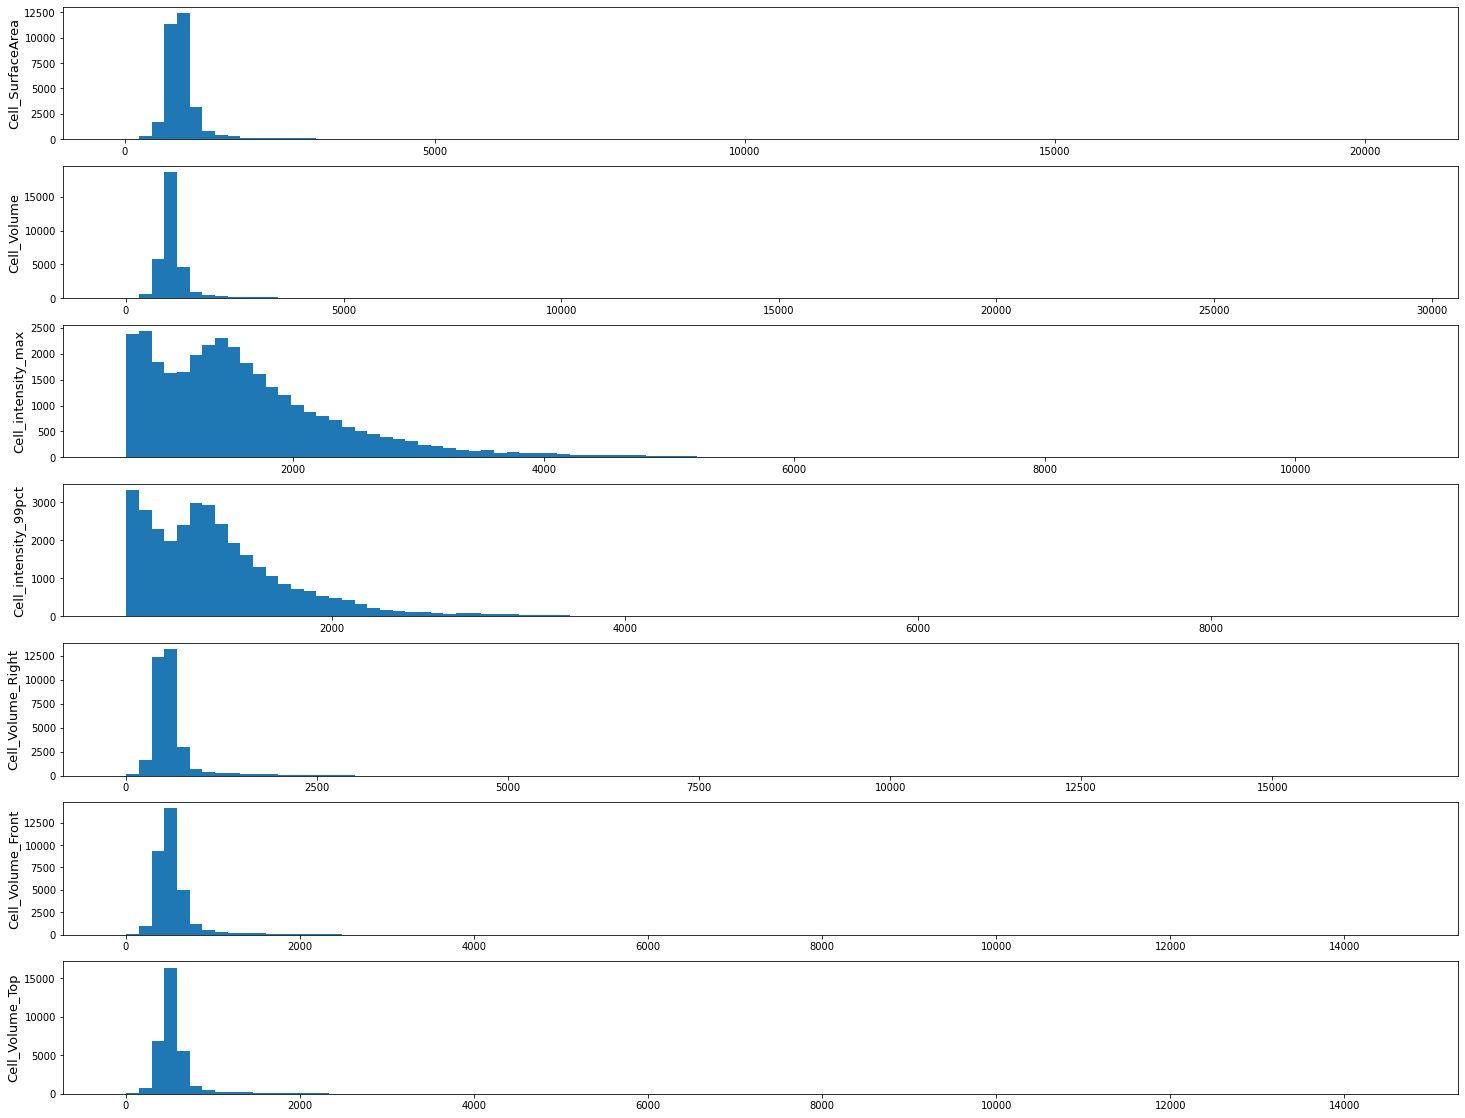

In [2]:
#################### Check shape distributions for extreme outliers before PCA ####################
import matplotlib.pyplot as plt
from CustomFunctions.file_management import multicsv
folder_fl = 'E:/Aaron/Galvanotaxis_Confocal_40x_37C_10s/'
data_fl = folder_fl + 'Data_and_Figs/'
info_fl = folder_fl + 'Processed_Data/'

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics.csv')

excludes = pd.read_csv(data_fl + 'ListToExclude.csv', index_col=0)
exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
df = df.loc[[x for x in df.index if x not in exlist]]

#add all of the other metrics from the single csv files
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [info_fl + i +'_cell_info.csv' for i in df.cell.to_list()]
    celllist = pool.map(multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist)
# Add distance travelled per framerate to total frame
df = df.merge(cellinfo.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')

metrics = df.std().sort_values(ascending = False).index[:7]
# df = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)]
# df = df[df.Cell_SurfaceArea < 1800]
fig, axes = plt.subplots(len(metrics), 1, figsize=(25,20))#, sharex=True)
for i, ax in enumerate(axes):
    ax.hist(abs(df[metrics[i]]), 100) #, 30, (-2,2))
    ax.set_ylabel(metrics[i], fontsize = 13)
# #volume threshold determined by looking through cropped cell images
newdf = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)].copy()
newdf = newdf[(newdf.Cell_SurfaceArea < 1800) & (newdf.Cell_SurfaceArea > 500)]

newdf.to_csv(data_fl + 'Shape_Metrics_outliersremoved.csv')

In [9]:
newdf = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)].copy()
newdf.Cell_SurfaceArea.sort_values(ascending=True).head(225)

cell
20231019_488EGFP-CAAX_1_cell_21_frame_139     351.532452
20231019_488EGFP-CAAX_1_cell_11_frame_107     351.771374
20231019_488EGFP-CAAX_1_cell_11_frame_126     352.158059
20231019_488EGFP-CAAX_1_cell_21_frame_152     352.180539
20231019_488EGFP-CAAX_1_cell_11_frame_115     352.402220
                                                 ...    
20231019_488EGFP-CAAX_1_cell_20_frame_20      476.895371
20231019_488EGFP-CAAX_1_cell_6_frame_119      477.874226
20231019_488EGFP-CAAX_1_cell_20_frame_22      480.052571
20231019_488EGFP-CAAX_1_cell_20_frame_78      481.830637
20231019_488EGFP-CAAX_1_cell_108_frame_339    482.725788
Name: Cell_SurfaceArea, Length: 225, dtype: float64

In [15]:
df.Cell_Volume.sort_values(ascending=False).head(250)
# df.Cell_Volume.std()*3.5

cell
20231019_488EGFP-CAAX_2_cell_0_frame_125      41171.824758
20231019_488EGFP-CAAX_2_cell_0_frame_126      39045.207103
20231019_488EGFP-CAAX_1_cell_32_frame_303     35755.608704
20231020_488EGFP-CAAX_1_cell_61_frame_231     34064.992314
20231020_488EGFP-CAAX_1_cell_11_frame_136     33175.861057
                                                  ...     
20231019_488EGFP-CAAX_1_cell_99_frame_218      2479.344193
20231019_488EGFP-CAAX_1_cell_115_frame_351     2470.686063
20231019_488EGFP-CAAX_1_cell_140_frame_319     2467.212039
20231020_488EGFP-CAAX_1_cell_129_frame_280     2458.164162
20231019_488EGFP-CAAX_1_cell_140_frame_293     2456.941206
Name: Cell_Volume, Length: 250, dtype: float64

In [2]:
######### Perform PCA and divide cells into shape space bins ################

#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk

folder_fl = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_30C_10s/'
data_fl = folder_fl + 'Data_and_Figs/'


#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_outliersremoved.csv', index_col='cell')


#exclude cells with centroids outside the mesh

coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]



# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1

df_trans = df_trans.drop(columns = 'Cell_Volume')



################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})

    
mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine metrics and digitized pcs
df_dig = df.merge(df_dig, left_index = True, right_index = True)
#save
df_dig.to_csv(data_fl+"Shape_Metrics_with_Digitized_PCs.csv")


########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

                
                
################## save PC meshes ##################
savedir = folder_fl + 'PC_Meshes/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(savedir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()

####### also save the pca object for later use ###########
pk.dump(pca, open(data_fl+"pca.pkl","wb"))



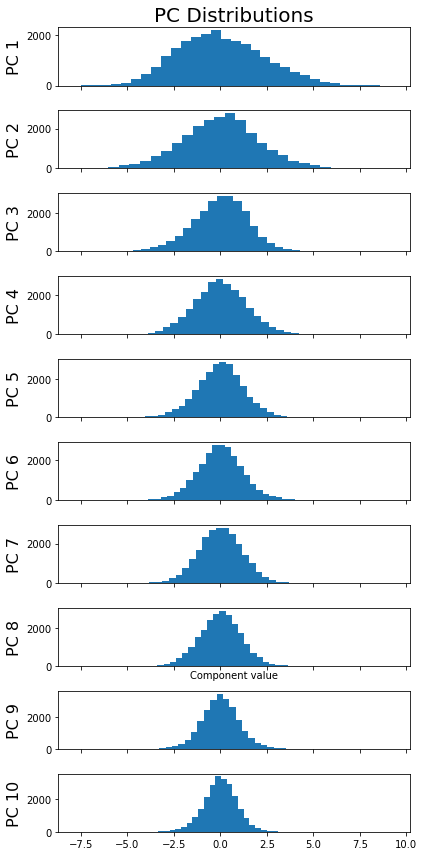

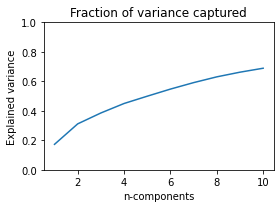

In [7]:
folder_fl = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_30C/'
data_fl = folder_fl + 'Data_and_Figs/'

########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(df_trans.iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(data_fl+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(data_fl + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = data_fl + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )